<a href="https://colab.research.google.com/github/hoihui/tutorial/blob/master/SequenceToSequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np, random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!pip3 install tensorflow==2.0.0-alpha0
import tensorflow as tf
from tensorflow import keras
tf.__version__,keras.__version__,tf.test.is_gpu_available()

('2.0.0-alpha0', '2.2.4-tf', False)

# Test Integer Sequences

https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/

- Input: sequence of 5 integers
- Output: the first two integers, then padded with 0; or other criterions

In [0]:
seqlen = 5
maxint = 60
batchsize = 32

## Generate Data

In [6]:
one_hot_decode = lambda X: np.argmax(X,axis=X.ndim-1)
 
def gen_pairs(batchsize=2, onehot=True):
    while True:
        X = np.random.randint(0, maxint-1,(batchsize,seqlen),dtype=int)
#         y = np.hstack((y[:,:2],np.zeros((batchsize,3),dtype=int)))  # original: first 2 integers
#         y = np.sort(maxint*np.sin(X/maxint),axis=1).astype(int)
#         y = np.sort(np.cumsum(X,1).astype(int)%maxint)
        y = (np.cumsum(X,1)/np.tile(X.sum(1),(seqlen,1)).T*(maxint-1)).astype(int)
        
        if onehot: #https://stackoverflow.com/a/49217762
            I = np.eye(maxint)
            X = I[X.reshape(-1)].reshape(*X.shape,maxint)
            y = I[y.reshape(-1)].reshape(*y.shape,maxint)
        
        yield X,y

X,y = next(gen_pairs(2,True))
print(X.shape,y.shape)    
X,y = next(gen_pairs(2,False))
X,y

(2, 5, 60) (2, 5, 60)


(array([[34, 38, 39, 54, 50],
        [ 8,  6, 23, 29,  1]]), array([[ 9, 19, 30, 45, 59],
        [ 7, 12, 32, 58, 59]]))

## Keras Models

### Without Attention

In [8]:
# w/o Attention Accuracy: 0.662
cellSize = 32
model = tf.keras.models.Sequential()
# model.add(keras.layers.LSTM(cellSize, input_shape=(seqlen, maxint)))  #original
# model.add(keras.layers.RepeatVector(seqlen))                          #original
# model.add(keras.layers.LSTM(cellSize, return_sequences=True))         #original
model.add(keras.layers.Bidirectional(keras.layers.LSTM(cellSize, return_sequences=True), input_shape=(seqlen, maxint)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(cellSize, return_sequences=True)))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(maxint,
                                                          activation='softmax')
                                      ))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 5, 64)             23808     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 5, 64)             24832     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 60)             3900      
Total params: 52,540
Trainable params: 52,540
Non-trainable params: 0
_________________________________________________________________


### With Attention

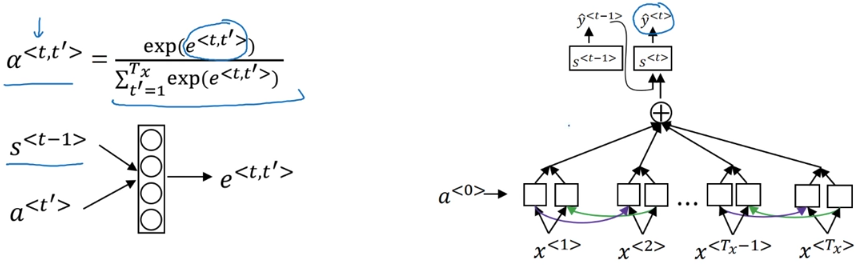

In [18]:
# https://www.cnblogs.com/hezhiyao/p/8747019.html Accuracy: 0.556
cellSize1 = 32
cellSize2 = 52  #chosen to have similar number of trainable parameters as above
X = tf.keras.Input(shape=(seqlen, maxint))           #(bs,seqlen,maxint)
# h0 = tf.keras.Input(shape=(cellSize2, ), name='h0')  # original codes for 2nd LSTM
# c0 = tf.keras.Input(shape=(cellSize2, ), name='c0')

a = tf.keras.layers.Bidirectional(keras.layers.LSTM(cellSize1,
                                                    return_sequences = True))(X) #(bs,seqlen,2*cellSize1)

# define trainable layers here so that weights are shared over the output layer
dense1 = tf.keras.layers.Dense(10, activation = "tanh")
dense2 = tf.keras.layers.Dense(1, activation = "relu")
lstm = tf.keras.layers.LSTM(cellSize2, return_state = True)
dense = tf.keras.layers.Dense(maxint, activation='softmax')

outputs = []
for t in range(seqlen):
    if t==0:
        context = tf.keras.backend.sum(a,axis=1)/seqlen
        context = tf.expand_dims(context,1)
        _, h, c = lstm(context)                                 #(bs,cellSize2)*3
    else:
        prevh = tf.keras.layers.RepeatVector(seqlen)(h)          #(bs,seqlen,cellSize2)
        concat = tf.keras.layers.concatenate([a,prevh], axis=-1) #(bs,seqlen,2*cellSize1+cellSize2)
        e = dense1(concat)                                       #(bs,seqlen,10) 
        e = dense2(e)                                            #(bs,seqlen,1)  
        attn = tf.nn.softmax(e,axis=1)                           #(bs,seqlen,1)  #softmax applied on 2nd dim
        context = tf.keras.layers.dot([attn,a],axes=1)           #(bs,1,2*cellSize1) = sum_t' alpha_tt'*a_t'
        _, h, c = lstm(context, initial_state = [h, c])          #(bs,cellSize2)*3
         
    out = dense(h)                                               #(bs,maxint)
    outputs.append(out)                                          #eventually (seqlen,bs,maxint)

outputs = tf.stack(outputs, axis=1)                              #(bs,seqlen,maxint)
model = tf.keras.Model(inputs=X, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary(line_length=125)

Model: "model_6"
_____________________________________________________________________________________________________________________________
Layer (type)                             Output Shape               Param #        Connected to                              
input_8 (InputLayer)                     [(None, 5, 60)]            0                                                        
_____________________________________________________________________________________________________________________________
bidirectional_11 (Bidirectional)         (None, 5, 64)              23808          input_8[0][0]                             
_____________________________________________________________________________________________________________________________
Sum_7 (TensorFlowOpLayer)                [(None, 64)]               0              bidirectional_11[0][0]                    
_____________________________________________________________________________________________________

In [0]:
# https://github.com/tensorflow/addons/tree/master/tensorflow_addons/seq2seq

## Train and Evaluate

In [19]:
# Train
import tempfile
_,weightsfile=tempfile.mkstemp()
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es=EarlyStopping(monitor='val_acc', patience=3, verbose=1)
mc=ModelCheckpoint(weightsfile,monitor='val_acc',save_best_only=True,save_weights_only=True,verbose=0)

model.fit_generator(gen_pairs(32, True), steps_per_epoch=2000, epochs=1000,callbacks=[es,mc],
                    validation_data=gen_pairs(128, True),validation_steps=100)
model.load_weights(weightsfile)

2000/2000 [==============================] - 26s 13ms/step - loss: 0.3255 - acc: 0.8770 - val_loss: 0.3293 - val_acc: 0.8750
Epoch 30/1000
2000/2000 [==============================] - 25s 13ms/step - loss: 0.3192 - acc: 0.8790 - val_loss: 0.3033 - val_acc: 0.8875
Epoch 31/1000
2000/2000 [==============================] - 25s 13ms/step - loss: 0.3162 - acc: 0.8799 - val_loss: 0.3127 - val_acc: 0.8820
Epoch 32/1000
2000/2000 [==============================] - 26s 13ms/step - loss: 0.3121 - acc: 0.8811 - val_loss: 0.3187 - val_acc: 0.8769
Epoch 33/1000
2000/2000 [==============================] - 26s 13ms/step - loss: 0.3061 - acc: 0.8835 - val_loss: 0.3134 - val_acc: 0.8844
Epoch 00033: early stopping


In [20]:
# Evaluate
X,y = next(gen_pairs(100000,True))
yhat = model.predict(X, verbose=0)
wrong = list(map(np.any, one_hot_decode(y)-one_hot_decode(yhat))) #np.any returns true (1) if any element is nonzero
print(f'Accuracy: {1-sum(wrong)/y.shape[0]}%') # different from acc during training as we count the WHOLE sequence as right/wrong here

for i in np.where(wrong)[0][:10]:   # output examples that are wrong
    print(f'True:{one_hot_decode(y[i])}, Prediction:{one_hot_decode(yhat[i])}')

Accuracy: 0.55623%
True:[12 20 26 43 59], Prediction:[12 19 26 43 59]
True:[14 29 40 51 59], Prediction:[14 29 41 51 59]
True:[ 2  9 25 34 59], Prediction:[ 2  9 24 34 59]
True:[ 2 10 31 44 59], Prediction:[ 2 10 32 44 59]
True:[ 7  9 35 54 59], Prediction:[ 7  9 35 53 59]
True:[ 2 12 29 39 59], Prediction:[ 1 12 29 39 59]
True:[14 27 30 46 59], Prediction:[14 27 30 47 59]
True:[ 3 20 30 48 59], Prediction:[ 3 21 30 48 59]
True:[11 28 46 54 59], Prediction:[12 28 46 54 59]
True:[16 33 33 44 59], Prediction:[16 33 33 43 59]


# Translate dates to standard format

* https://www.coursera.org/learn/nlp-sequence-models/notebook/npjGi/neural-machine-translation-with-attention
* https://www.cnblogs.com/hezhiyao/p/8747019.html

## Generate Data

In [22]:
dict(enumerate('01234567890/'))

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '0',
 11: '/'}

In [0]:
one_hot_decode = lambda X: np.argmax(X,axis=X.ndim-1)
 
def gen_pairs(batchsize=2, onehot=True):
    while True:
        X = np.random.randint(0, maxint-1,(batchsize,seqlen),dtype=int)
#         y = np.hstack((y[:,:2],np.zeros((batchsize,3),dtype=int)))  # original: first 2 integers
#         y = np.sort(maxint*np.sin(X/maxint),axis=1).astype(int)
#         y = np.sort(np.cumsum(X,1).astype(int)%maxint)
        y = (np.cumsum(X,1)/np.tile(X.sum(1),(seqlen,1)).T*(maxint-1)).astype(int)
        
        if onehot: #https://stackoverflow.com/a/49217762
            I = np.eye(maxint)
            X = I[X.reshape(-1)].reshape(*X.shape,maxint)
            y = I[y.reshape(-1)].reshape(*y.shape,maxint)
        
        yield X,y

X,y = next(gen_pairs(2,True))
print(X.shape,y.shape)    
X,y = next(gen_pairs(2,False))
X,y

# Encoder-Decoder

https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention

In [0]:
import urllib, os, tempfile, zipfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip','spa-eng.zip')
zipfile.ZipFile('spa-eng.zip').extractall()
# ./spa-eng/spa.txt

In [0]:
import unicodedata, re

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # "he is a boy." => "he is a boy ." (https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation)
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'
    return w

print(preprocess_sentence("May I borrow this book?"))
print(preprocess_sentence("¿Puedo tomar prestado este libro?").encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'
